<a href="https://colab.research.google.com/github/sdgroeve/D012554_Machine_Learning_2023/blob/main/02_neural_networks_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Neural networks in PyTorch


In [134]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In this notebook we will analyse a two-class dataset that requires a model that is more complex than the logistic regression model.

We will build and train a neural network for this dataset.

First we import the required PyTorch libraries and fix the random seed.

In [135]:
import torch
from torch import nn 

torch.manual_seed(46)

# Check PyTorch version
torch.__version__

'1.13.1+cu116'

## Preparing the data

The dataset is in a flat file called `dataset_neural_networks.csv`. 

We read this file into a Pandas DataFrame.

In [136]:
import pandas as pd

dataset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/D012554_Machine_Learning_2023/main/datasets/dataset_neural_networks.csv")

dataset.head()

,x_1,x_2,y
0,-0.981663,1.239569,0
1,-0.857931,0.765202,0
2,-1.435887,0.849735,0
3,0.517317,0.993574,1
4,-0.582966,-0.709132,1


The dataset as two features `x_1` and `x_2`, and one label `y`. 

Let's plot this data. 

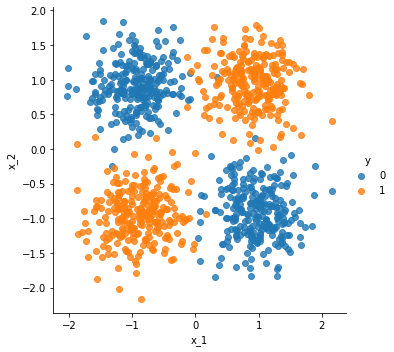

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(x="x_1",y="x_2",hue="y",data=dataset,fit_reg=False)
plt.show()

We put the feature columns in a DataFrame called `X` and the label column in a DataFrame called `y`.

In [138]:
y = dataset.pop('y')
X = dataset

We create a train, a validation and a test split of the dataset.


In [139]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(800, 2)
(100, 2)
(100, 2)


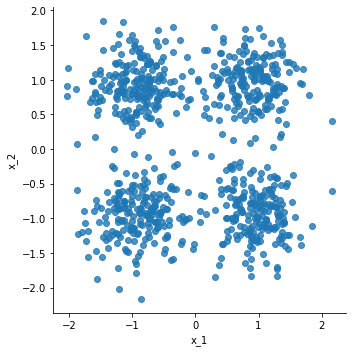

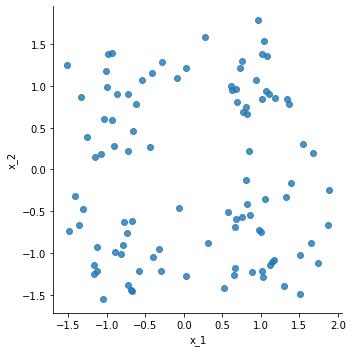

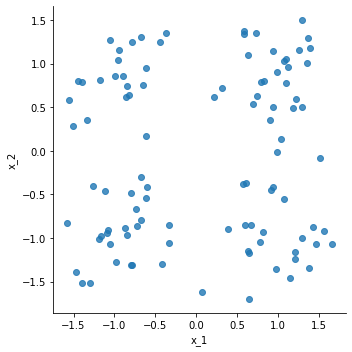

In [140]:
sns.lmplot(x="x_1",y="x_2",data=X_train,fit_reg=False)
plt.show()
sns.lmplot(x="x_1",y="x_2",data=X_val,fit_reg=False)
plt.show()
sns.lmplot(x="x_1",y="x_2",data=X_test,fit_reg=False)
plt.show()

We create tensors from these splits.

In [141]:
X_train, X_val, X_test = torch.Tensor(X_train.values),torch.Tensor(X_val.values),torch.Tensor(X_test.values)
y_train, y_val, y_test = torch.Tensor(y_train.values),torch.Tensor(y_val.values),torch.Tensor(y_test.values)

## Building the model

To build a model in PyTorch we need to create a subclass of `torch.nn.Module` such that this subclass inherits all functionality required for fitting our model.

In [142]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=4)
        self.layer_2 = nn.Linear(in_features=4, out_features=output_dim)
        #self.layer_3 = nn.Linear(in_features=10, out_features=output_dim)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_2(self.relu(self.layer_1(x)))
"""
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=4)
        self.layer_2 = nn.Linear(in_features=4, out_features=output_dim)
        self.sigmoid = nn.Sigmoid()
        #torch.nn.init.uniform_(self.layer_1.weight) 
        #torch.nn.init.uniform_(self.layer_2.weight) 


    def forward(self, x):
       return self.layer_2(self.sigmoid(self.layer_1(x)))
"""

'\nclass NeuralNetwork(nn.Module):\n    def __init__(self, input_dim, output_dim):\n        super().__init__()\n        self.layer_1 = nn.Linear(in_features=input_dim, out_features=4)\n        self.layer_2 = nn.Linear(in_features=4, out_features=output_dim)\n        self.sigmoid = nn.Sigmoid()\n        #torch.nn.init.uniform_(self.layer_1.weight) \n        #torch.nn.init.uniform_(self.layer_2.weight) \n\n\n    def forward(self, x):\n       return self.layer_2(self.sigmoid(self.layer_1(x)))\n'

### `__init()__`

The method `__init__()` is called when an instance of our class `NeuralNetwork` is created. This is done in the following code.

In [143]:
# Two inputs x_1 and x_2
input_dim = 2  
# Single binary output 
output_dim = 1 

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model = NeuralNetwork(input_dim, output_dim)

model.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.2278, -0.6223],
                      [ 0.0246, -0.4814],
                      [ 0.3607,  0.4794],
                      [-0.6118, -0.0522]])),
             ('layer_1.bias', tensor([-0.4982, -0.1984,  0.6120, -0.6830])),
             ('layer_2.weight',
              tensor([[ 0.4736, -0.0892,  0.3620,  0.3799]])),
             ('layer_2.bias', tensor([0.1569]))])

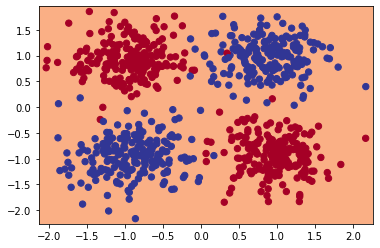

In [144]:
plot_decision_boundary(model, X_train, y_train)

### `forward()`

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined. 

Let's make some predictions for the first 10 feature vectors in the test set.

In [145]:
with torch.inference_mode(): 
    predictions = model(X_test[:10])

predictions = torch.squeeze(predictions).detach().numpy()

predictions

array([0.15488063, 0.19842899, 0.38829464, 0.150008  , 0.3965295 ,
       0.70475185, 0.68636966, 0.69728506, 0.43407002, 0.76391745],
      dtype=float32)

Now we can compute evaluation metrics for the predicitons, e.g. the AUC.

In [146]:
from sklearn.metrics import roc_auc_score

with torch.inference_mode(): 
    predictions = model(X_test)

predictions = torch.squeeze(predictions).detach().numpy()

print("test set AUC: {}".format(roc_auc_score(y_test,predictions)))

test set AUC: 0.482020202020202


## Training the model

Our model is making predictions using random modelparameter values.


For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

To train the model we need to add a **loss function** and an **optimizer**. The loss function measures how wrong the model predictions are compared to the true labels. The optimizer tells your model how to update its modelparameters to best lower the loss.

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems or cross entropy loss function for classification problems, as for our dataset. 

For the optimizer we will SGD, `torch.optim.SGD(params, lr)` where:

* `params` are the modelparameters we want to optimize
* `lr` is the **learning rate** you'd like the optimizer to update the modelparameters at

In [147]:
learning_rate = 0.03

#the loss function
loss_func = torch.nn.BCEWithLogitsLoss()

#the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Now we've got a loss function and an optimizer, it's now time to create a **training loop** (and **validation loop**).

For the training loop, we have to code the following steps:

1. Forward pass: the model goes through all of the training data once, performing its `forward()` function calculations.

2. Calculate the loss: the model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.
3. Zero the gradients: the optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.
4. Perform backpropagation on the loss: computes the gradient of the loss with respect to every modelparameter 
5. Update the optimizer (**gradient descent**): update the modelparameter values with respect to the loss gradients.


In [148]:
#number of times we iterate trough the train set
num_epochs = 10000

for epoch in range(num_epochs):

    #step 1
    predictions_train = torch.squeeze(model(X_train)) 

    #step 2
    loss = loss_func(predictions_train, y_train) 

    #step 3
    optimizer.zero_grad() 

    #step 4
    loss.backward() 

    #step 5
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
        
    if epoch % 500 == 0:    
      #compute AUC on validation set
      predictions_val = torch.squeeze(model(X_val)).round().detach().numpy()
      #print(predictions_val)
      print("training loss: {}".format(loss))    
      print("validation AUC: {}".format(roc_auc_score(y_val,predictions_val)))

training loss: 0.7274726033210754
validation AUC: 0.6258012820512822
training loss: 0.3973722755908966
validation AUC: 0.9825721153846154
training loss: 0.19813965260982513
validation AUC: 0.9901842948717948
training loss: 0.13826721906661987
validation AUC: 0.9943910256410257
training loss: 0.11140010505914688
validation AUC: 0.9959935897435898
training loss: 0.09628619253635406
validation AUC: 0.9963942307692308
training loss: 0.086493119597435
validation AUC: 0.9967948717948718
training loss: 0.07939927279949188
validation AUC: 0.9969951923076923
training loss: 0.0741051584482193
validation AUC: 0.9971955128205128
training loss: 0.07002664357423782
validation AUC: 0.9987980769230769
training loss: 0.06683345139026642
validation AUC: 0.9989983974358975
training loss: 0.06425334513187408
validation AUC: 0.9989983974358975
training loss: 0.06213685870170593
validation AUC: 0.9989983974358974
training loss: 0.060384105890989304
validation AUC: 0.9993990384615384
training loss: 0.0589058

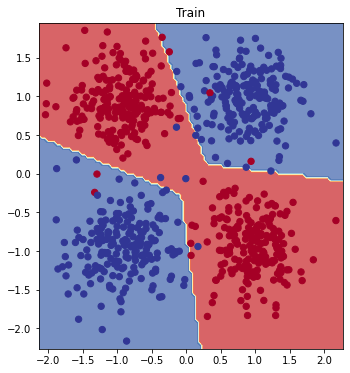

In [149]:


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)


## Computing predictions and evaluating the model


In [ ]:
model.eval()

with torch.inference_mode(): 
    predictions_test = model(X_test)

predictions_test = torch.squeeze(predictions_test).detach().numpy()

print("test set AUC: {}".format(roc_auc_score(y_test,predictions_test)))

test set AUC: 0.998792270531401


## Saving (and loading) the model

The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving a model for inference (making predictions) is by saving the modelparameter values in `state_dict()`.

We call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.


In [ ]:
model_filename = "model_logistic_regression.pth"
torch.save(obj=model.state_dict(), f=model_filename) 

To load a model, we first load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).


In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model = LogisticRegression(input_dim, output_dim)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f=model_filename))

<All keys matched successfully>

Excellent! It looks like things matched up.

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

Remember the rules for performing inference with PyTorch models?

If not, here's a refresher:

<details>
    <summary>PyTorch inference rules</summary>
    <ol>
      <li> Set the model in evaluation mode (<code>model.eval()</code>). </li>
      <li> Make the predictions using the inference mode context manager (<code>with torch.inference_mode(): ...</code>). </li>
      <li> All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).</li>
    </ol> 
</details>



In [ ]:
# 1. Put the loaded model into evaluation mode
loaded_model.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test) # perform a forward pass on the test data with the loaded model